In [87]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [88]:
def switch_to_list(source_folders):
    result = []  

    folders = os.listdir(source_folders)

    for folder in folders:
        folder_images = []  
        
        folder_path = os.path.join(source_folders, folder)
        files = os.listdir(folder_path)
        
        for file in files:
            source_path = os.path.join(folder_path, file)
            
            
            img = cv2.imread(source_path)
            
            
            folder_images.append(img)
        
        
        result.append(folder_images)
    
    return result

In [89]:
def print_each_list(image_list, count, Cmap=None):
    fig, axes = plt.subplots(len(image_list), count, figsize=(count*3, len(image_list)*3))
    
    for i, images in enumerate(image_list):
        
        images_to_show = images[:count]
        
        for j, image in enumerate(images_to_show):
            
            axes[i, j].imshow(image, cmap=Cmap)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [90]:
def grayscale(img):
     result = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
     return result

In [91]:
def preprocess(image_list):
    result = []
    
    for images in image_list:
        sub_result = []
        
        for img in images:
            
            processed_img = grayscale(img)
            
            sub_result.append(processed_img)
        
        result.append(sub_result)
    
    return result

In [92]:
def calculate_glcm(img, distances, angles):
    max_gray_level = 256
    glcm = np.zeros((max_gray_level, max_gray_level, len(distances), len(angles)), dtype=np.float64)
    rows, cols = img.shape

    for d, distance in enumerate(distances):
        for a, angle in enumerate(angles):
            dx = int(np.round(np.cos(angle) * distance))
            dy = int(np.round(np.sin(angle) * distance))
            
            for i in range(rows):
                for j in range(cols):
                    new_i = i + dy
                    new_j = j + dx
                    if 0 <= new_i < rows and 0 <= new_j < cols:
                        glcm[img[i, j], img[new_i, new_j], d, a] += 1

    glcm /= np.sum(glcm, axis=(0, 1), keepdims=True)
    return glcm

def extract_features(glcm):
    features = {}
    num_levels = glcm.shape[0]
    
    mean_i = np.sum(np.arange(num_levels)[:, None] * glcm, axis=(0, 1))
    mean_j = np.sum(np.arange(num_levels)[None, :] * glcm, axis=(0, 1))
    std_i = np.sqrt(np.sum((np.arange(num_levels)[:, None] - mean_i) ** 2 * glcm, axis=(0, 1)))
    std_j = np.sqrt(np.sum((np.arange(num_levels)[None, :] - mean_j) ** 2 * glcm, axis=(0, 1)))

    features['contrast'] = np.sum((np.arange(num_levels)[:, None] - np.arange(num_levels)[None, :]) ** 2 * glcm, axis=(0, 1))
    features['dissimilarity'] = np.sum(np.abs(np.arange(num_levels)[:, None] - np.arange(num_levels)[None, :]) * glcm, axis=(0, 1))
    features['homogeneity'] = np.sum(glcm / (1.0 + (np.arange(num_levels)[:, None] - np.arange(num_levels)[None, :]) ** 2), axis=(0, 1))
    features['energy'] = np.sqrt(np.sum(glcm ** 2, axis=(0, 1)))
    features['correlation'] = np.sum((np.arange(num_levels)[:, None] * np.arange(num_levels)[None, :] * glcm - mean_i * mean_j) / (std_i * std_j), axis=(0, 1))
    features['entropy'] = -np.sum(glcm * np.log2(glcm + (glcm == 0)), axis=(0, 1))
    features['asm'] = np.sum(glcm ** 2, axis=(0, 1))

    return features

def extract_features_glcm(grayscale_images, distances=[1, 2, 3, 4, 5], labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
):
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]  # 0, 45, 90, dan 135 derajat dalam satuan radian
    features_list = []

    for folder_index, folder_images in enumerate(grayscale_images):
        for img in folder_images:
            # img_features = []
            glcm = calculate_glcm(img, distances, angles)
            
            
            for d in range(len(distances)):
                features_at_angle = {}
                
                for a in range(len(angles)):
                    features = extract_features(glcm[:, :, d, a])
                    for key, value in features.items():
                        features_at_angle[f'{key}_{int(np.degrees(angles[a]))}'] = value
                features_at_angle['label'] = labels[folder_index]
                features_list.append(features_at_angle)
                
            
            
            # img_features.append(features_at_angle)
            # features_list.append(features_at_angle)
    
    return features_list

In [93]:
the_folders = 'E:/kuliah/semester 4/pengolahan citra digital/praktikum/projek/just use this'

In [94]:
the_list = switch_to_list(the_folders)

In [95]:
# print_each_list(the_list, 4)

In [96]:
preprocessed_list = preprocess(the_list)

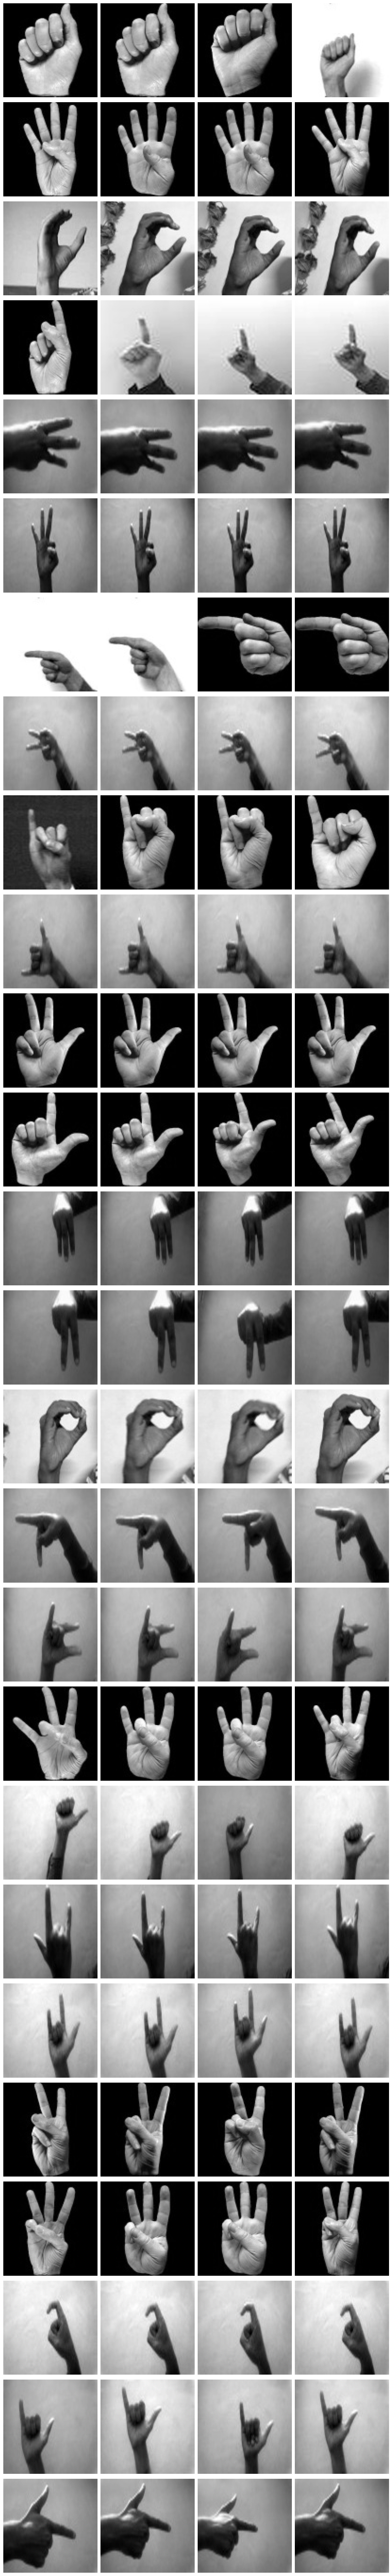

In [97]:
print_each_list(preprocessed_list, 4, "gray")

In [98]:
glcm_features = extract_features_glcm(preprocessed_list)

In [99]:
features_df = pd.DataFrame(glcm_features)

In [100]:
features_df.head(10)

contrast_0  dissimilarity_0  homogeneity_0  energy_0  correlation_0  \
0   278.428889         6.609091       0.517162  0.383393  -53273.102849   
1   765.299796        11.915306       0.468613  0.367610  -54266.918676   
2  1298.900206        16.673196       0.439421  0.353750  -55298.518979   
3  1849.151042        21.119583       0.415596  0.339512  -56370.096759   
4  2401.188105        25.329579       0.395226  0.326719  -57482.450556   
5   267.912525         6.515354       0.522352  0.402513  -51761.763150   
6   751.513673        11.769184       0.478559  0.387339  -52714.877348   
7  1287.119381        16.537732       0.449290  0.373158  -53703.751014   
8  1844.428542        21.045208       0.427151  0.358900  -54730.431429   
9  2406.864211        25.262526       0.406528  0.344908  -55795.095967   

   entropy_0     asm_0  contrast_45  dissimilarity_45  homogeneity_45  ...  \
0   7.393466  0.146990   412.105091          8.222630        0.500049  ...   
1   7.741695  0.135137   412.105091          8.222630        0.500049  ...   
2   7.985397  0.125139  1109.979384         15.027280        0.449423  ...   
3   8.185932  0.115268  1859.649272         21.231162        0.419978  ...   
4   8.354111  0.106745  2592.414388         26.912001        0.392607  ...   
5   7.254935  0.162017   401.434037          8.081930        0.507423  ...   
6   7.587857  0.150031   401.434037          8.081930        0.507423  ...   
7   7.836322  0.139247  1092.683673         14.795918        0.459582  ...   
8   8.022033  0.128809  1835.208949         20.947922        0.432753  ...   
9   8.208573  0.118962  2579.997504         26.733181        0.405460  ...   

   entropy_90    asm_90  contrast_135  dissimilarity_135  homogeneity_135  \
0    7.238468  0.155964    402.941537           8.223447         0.498864   
1    7.491752  0.147199    402.941537           8.223447         0.498864   
2    7.637404  0.143989   1009.943982          14.176177         0.454470   
3    7.760637  0.140130   1613.124030          19.104262         0.428165   
4    7.859973  0.136914   2154.716471          23.241428         0.406337   
5    7.107687  0.169742    380.033772           7.989491         0.504017   
6    7.345725  0.161243    380.033772           7.989491         0.504017   
7    7.486680  0.157348    971.387339          13.812578         0.461545   
8    7.594171  0.154016   1563.259751          18.660750         0.438114   
9    7.698405  0.150545   2111.571940          22.890951         0.414117   

   energy_135  correlation_135  entropy_135   asm_135  label  
0    0.379837    -54146.639250     7.517838  0.144276      A  
1    0.379837    -54146.639250     7.517838  0.144276      A  
2    0.361253    -55849.483097     7.859399  0.130504      A  
3    0.345677    -57511.016676     8.105966  0.119493      A  
4    0.330843    -59190.594891     8.310466  0.109457      A  
5    0.397875    -52544.624493     7.383972  0.158304      A  
6    0.397875    -52544.624493     7.383972  0.158304      A  
7    0.380920    -54169.387521     7.711795  0.145100      A  
8    0.364450    -55760.396208     7.957055  0.132824      A  
9    0.348098    -57378.854448     8.170201  0.121172      A  

[10 rows x 29 columns]

In [101]:
# features_df.to_csv('1.2 ekstraksi_fitur_sebelum.csv', index=False)

In [113]:
# features_df = pd.read_csv('1.2 ekstraksi_fitur_sebelum.csv')

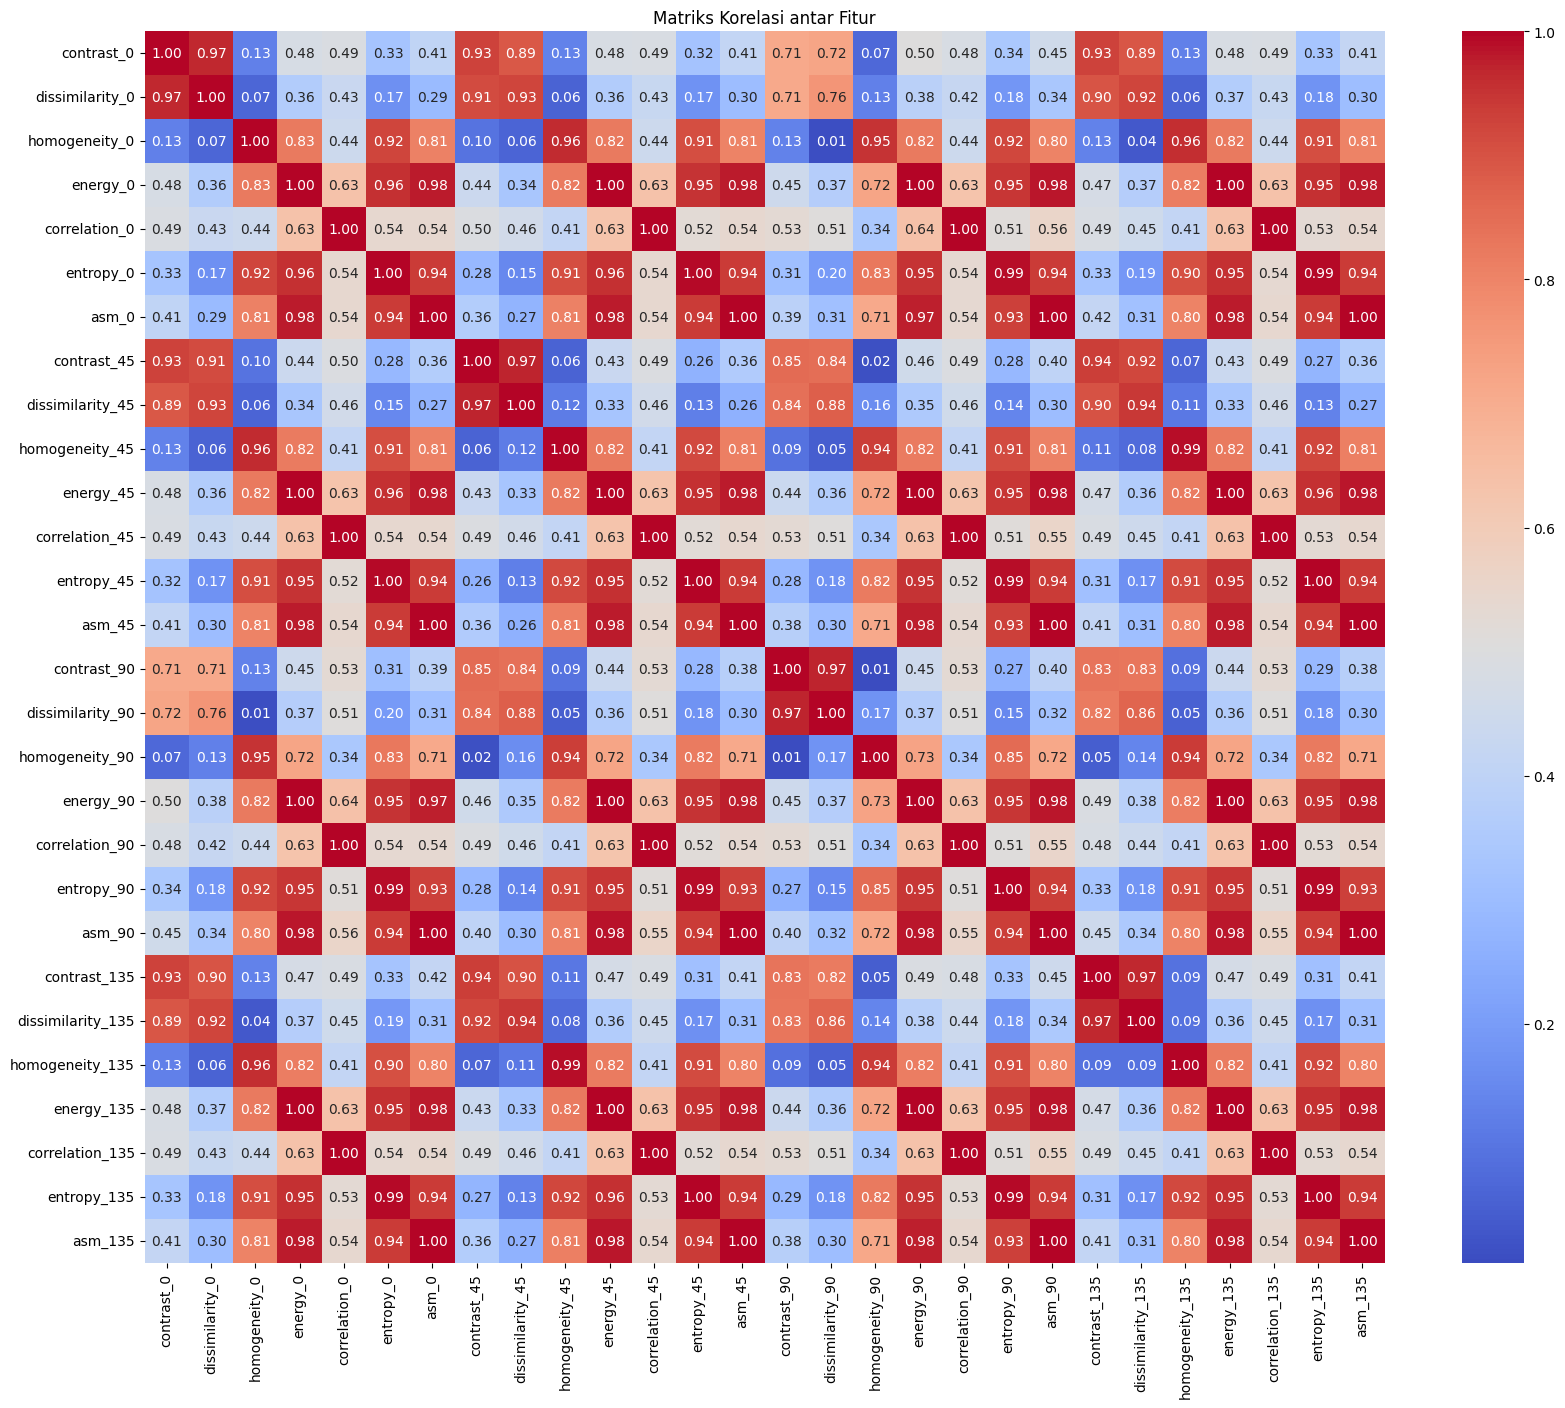

In [114]:
correlation_matrix = features_df.drop('label', axis=1).corr().abs()

plt.figure(figsize=(20, 16))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Matriks Korelasi antar Fitur')

plt.show()

In [115]:
features_to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.9:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]

            features_to_drop.add(col2)

filtered_features_df = features_df.drop(columns=list(features_to_drop))

In [117]:
# filtered_features_df.to_csv('filtered 1.2 ekstraksi_fitur_sebelum.csv', index=False)

In [ ]:
# filtered_features_df = pd.read_csv('filtered 1.2 ekstraksi_fitur_sebelum.csv')

In [105]:
# filtered_features_df = features_df[['contrast_0', 'homogeneity_0', 'energy_0', 'correlation_0', 'entropy_0', 'label']]

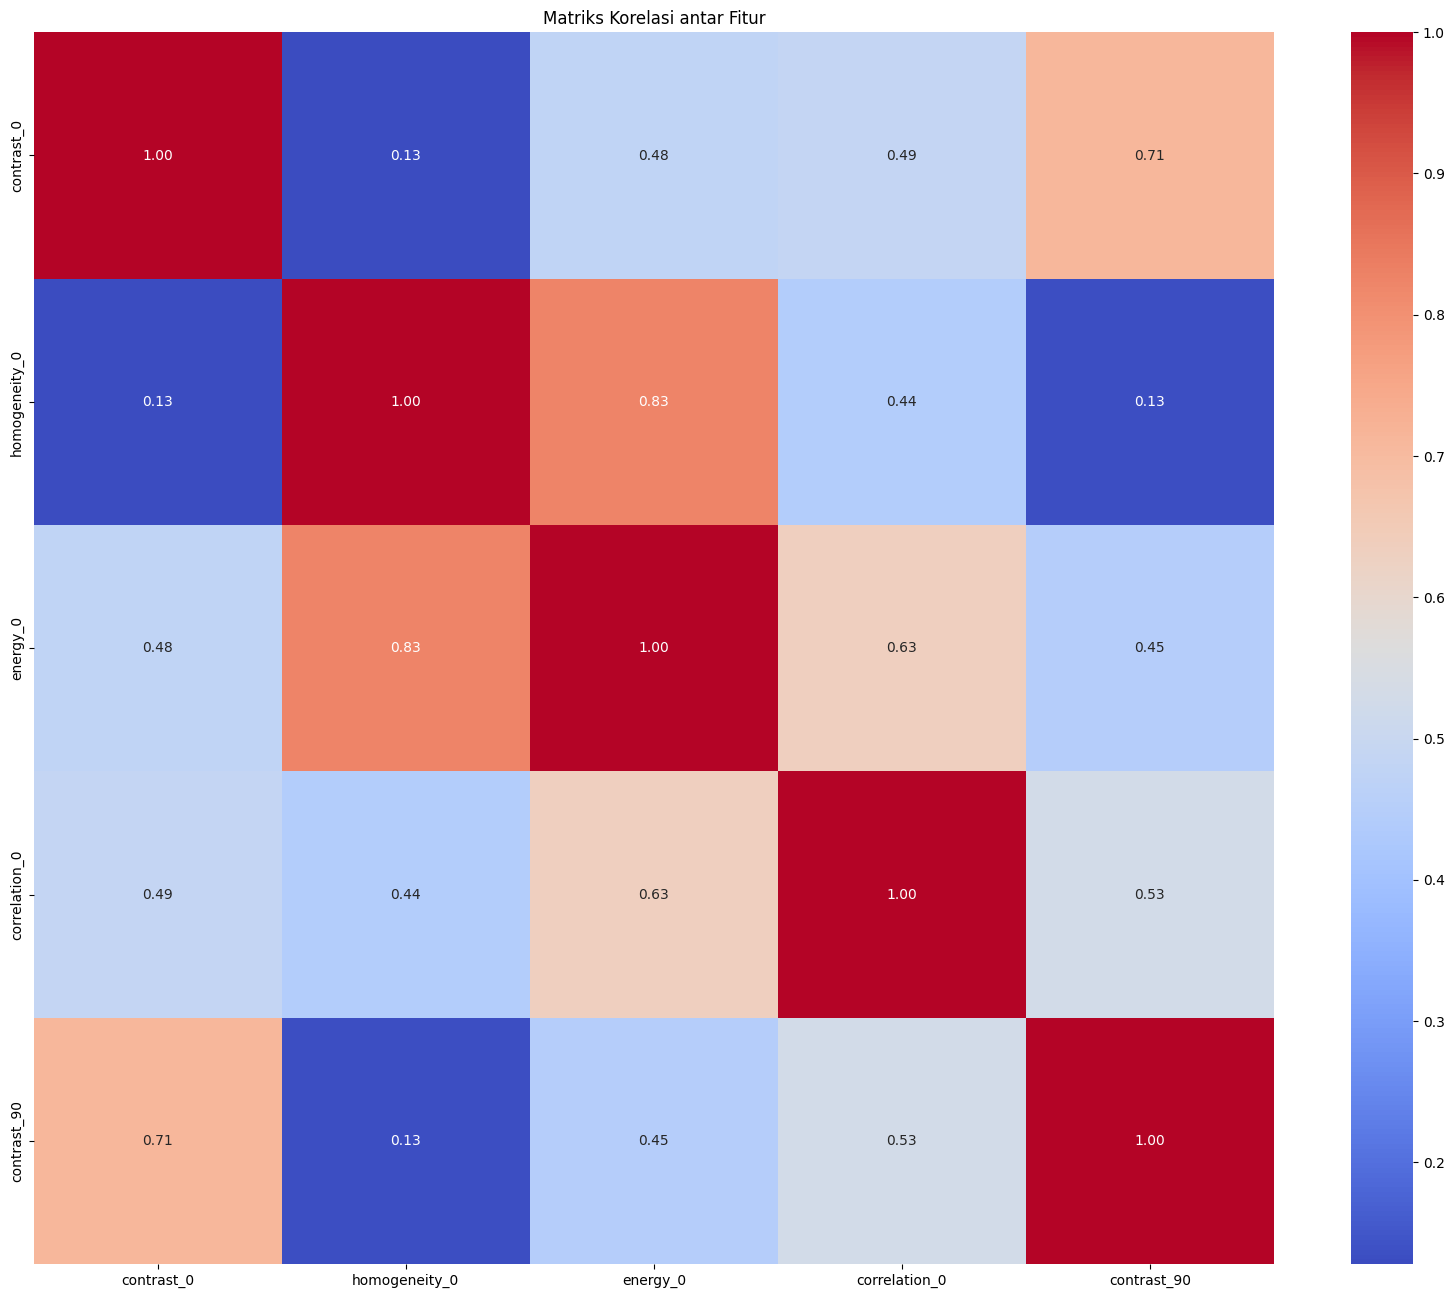

In [116]:
correlation_matrix_2 = filtered_features_df.drop('label', axis=1).corr().abs()

plt.figure(figsize=(20, 16))

sns.heatmap(correlation_matrix_2, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Matriks Korelasi antar Fitur')

plt.show()

In [107]:
XX = filtered_features_df.drop(columns=['label']).values
yy = filtered_features_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.20, random_state=42)

In [108]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [109]:
hasil_model = {
    'KNN': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []},
    'SVM': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []},
    'Random Forest': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
}

In [110]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
report_knn = classification_report(y_test, y_pred_knn, output_dict=True, zero_division=0)
hasil_model['KNN']['accuracy'].append(report_knn['accuracy'])
hasil_model['KNN']['precision'].append(report_knn['weighted avg']['precision'])
hasil_model['KNN']['recall'].append(report_knn['weighted avg']['recall'])
hasil_model['KNN']['f1_score'].append(report_knn['weighted avg']['f1-score'])

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True, zero_division=0)
hasil_model['SVM']['accuracy'].append(report_svm['accuracy'])
hasil_model['SVM']['precision'].append(report_svm['weighted avg']['precision'])
hasil_model['SVM']['recall'].append(report_svm['weighted avg']['recall'])
hasil_model['SVM']['f1_score'].append(report_svm['weighted avg']['f1-score'])

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
hasil_model['Random Forest']['accuracy'].append(report_rf['accuracy'])
hasil_model['Random Forest']['precision'].append(report_rf['weighted avg']['precision'])
hasil_model['Random Forest']['recall'].append(report_rf['weighted avg']['recall'])
hasil_model['Random Forest']['f1_score'].append(report_rf['weighted avg']['f1-score'])

df_hasil = pd.DataFrame(hasil_model).T
print(df_hasil)


                           accuracy             precision  \
KNN            [0.8226923076923077]  [0.8207885628561908]   
SVM            [0.6584615384615384]  [0.6770549693227219]   
Random Forest  [0.8780769230769231]   [0.878185074053791]   

                             recall              f1_score  
KNN            [0.8226923076923077]  [0.8191117682169164]  
SVM            [0.6584615384615384]  [0.6476736047527042]  
Random Forest  [0.8780769230769231]  [0.8768306829391792]  


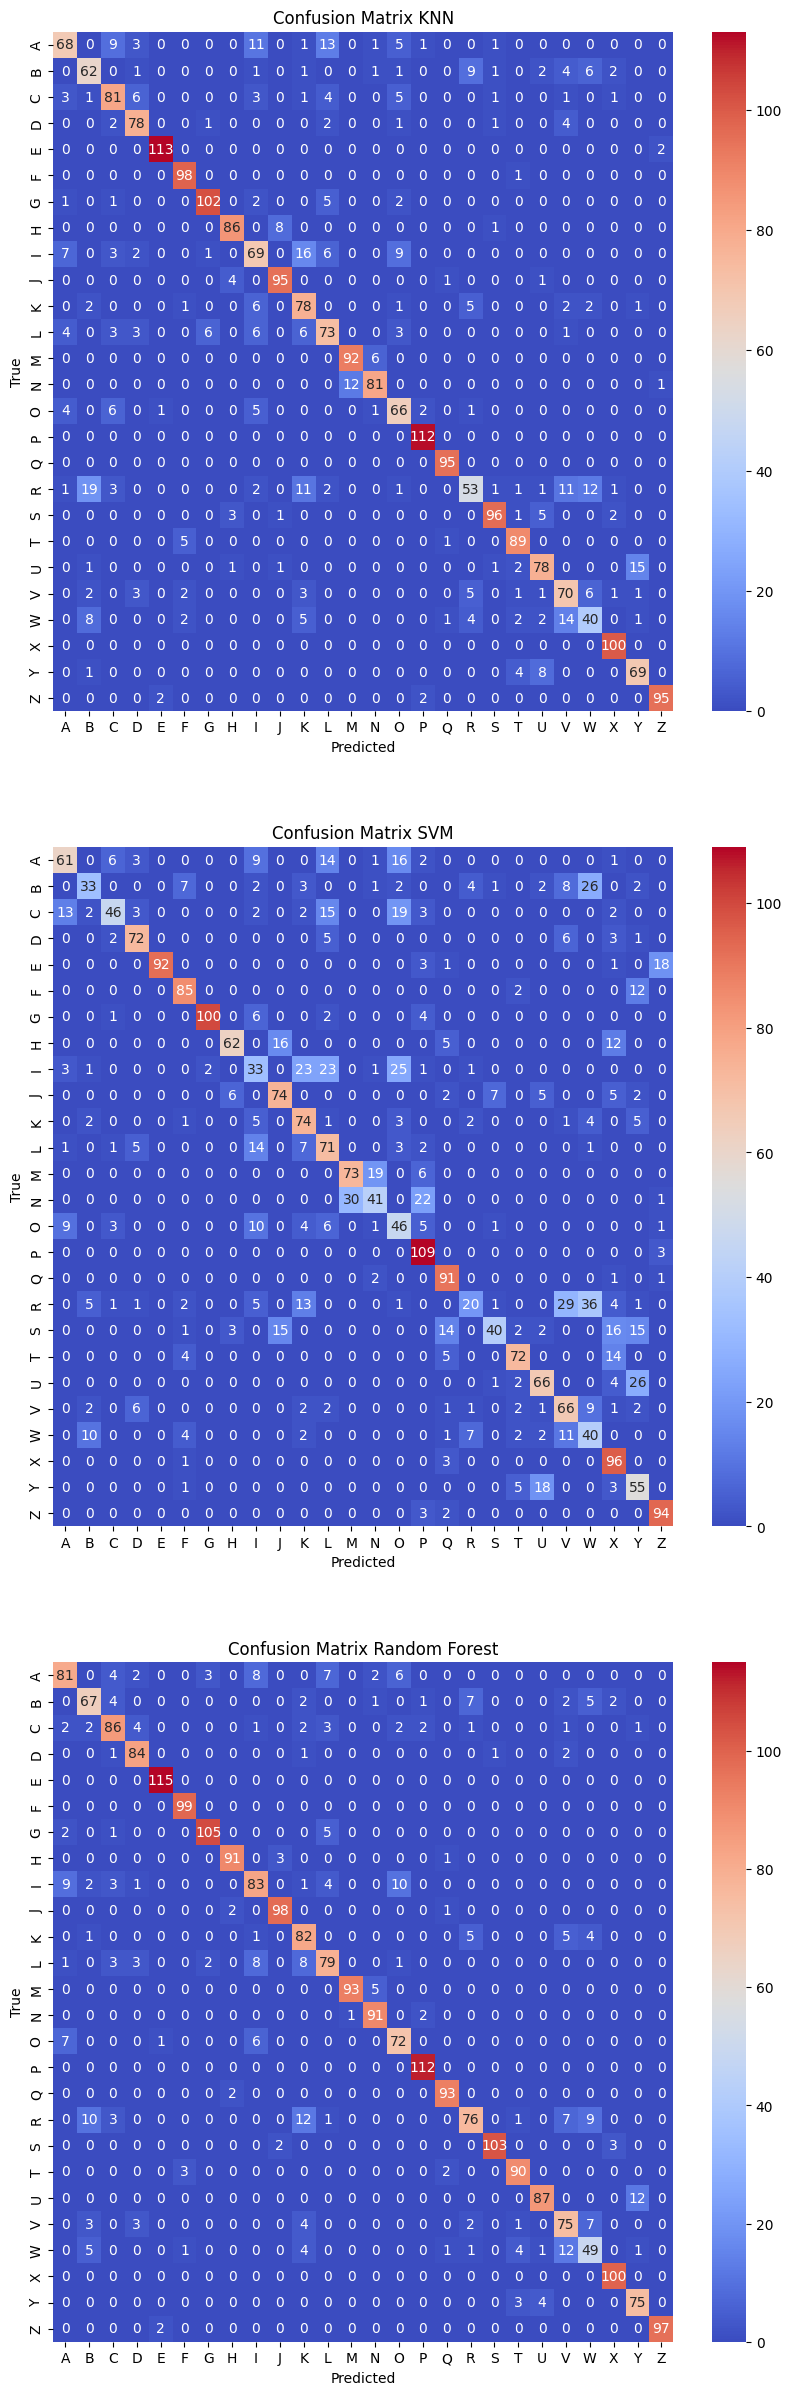

In [111]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y_test, y_pred_rf)

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

num_classes = len(np.unique(y_test))
labels = labels[:num_classes]

fig, axes = plt.subplots(3, 1, figsize=(10, 30))

sns.heatmap(cm_knn, annot=True, cmap='coolwarm', fmt='g', ax=axes[0], xticklabels=labels, yticklabels=labels)
axes[0].set_title('Confusion Matrix KNN')
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_svm, annot=True, cmap='coolwarm', fmt='g', ax=axes[1], xticklabels=labels, yticklabels=labels)
axes[1].set_title('Confusion Matrix SVM')
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

sns.heatmap(cm_rf, annot=True, cmap='coolwarm', fmt='g', ax=axes[2], xticklabels=labels, yticklabels=labels)
axes[2].set_title('Confusion Matrix Random Forest')
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("True")

plt.show()

In [112]:
#cross validation

XX = filtered_features_df.drop(columns=['label']).values
yy = filtered_features_df['label'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_x = {
    'KNN': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []},
    'SVM': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []},
    'Random Forest': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
}

for train_index, test_index in kf.split(XX):
    X_train, X_test = XX[train_index], XX[test_index]
    y_train, y_test = yy[train_index], yy[test_index]
    

    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    report_knn = classification_report(y_test, y_pred_knn, output_dict=True, zero_division=0)
    results_x['KNN']['accuracy'].append(report_knn['accuracy'])
    results_x['KNN']['precision'].append(report_knn['weighted avg']['precision'])
    results_x['KNN']['recall'].append(report_knn['weighted avg']['recall'])
    results_x['KNN']['f1_score'].append(report_knn['weighted avg']['f1-score'])
    
    
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    report_svm = classification_report(y_test, y_pred_svm, output_dict=True, zero_division=0)
    results_x['SVM']['accuracy'].append(report_svm['accuracy'])
    results_x['SVM']['precision'].append(report_svm['weighted avg']['precision'])
    results_x['SVM']['recall'].append(report_svm['weighted avg']['recall'])
    results_x['SVM']['f1_score'].append(report_svm['weighted avg']['f1-score'])
    
    
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
    results_x['Random Forest']['accuracy'].append(report_rf['accuracy'])
    results_x['Random Forest']['precision'].append(report_rf['weighted avg']['precision'])
    results_x['Random Forest']['recall'].append(report_rf['weighted avg']['recall'])
    results_x['Random Forest']['f1_score'].append(report_rf['weighted avg']['f1-score'])


average_results = {
    'KNN': {metric: np.mean(values) for metric, values in results_x['KNN'].items()},
    'SVM': {metric: np.mean(values) for metric, values in results_x['SVM'].items()},
    'Random Forest': {metric: np.mean(values) for metric, values in results_x['Random Forest'].items()}
}

df_results = pd.DataFrame(average_results).T
print(df_results)

               accuracy  precision    recall  f1_score
KNN            0.393077   0.402395  0.393077  0.391738
SVM            0.225538   0.202581  0.225538  0.166129
Random Forest  0.887231   0.887512  0.887231  0.886453


               accuracy  precision    recall  f1_score
KNN            0.335308   0.338473  0.335308  0.331221
SVM            0.225538   0.202550  0.225538  0.166117
Random Forest  0.822538   0.824009  0.822538  0.821714